In [1]:
from __future__ import print_function
import hoomd
import hoomd.hpmc
import ex_render
from matplotlib import pyplot
import numpy
import sys
%matplotlib inline

# Quick compression scheme

You can compress a system from a random dilute configuration to a high packing fraction quickly by forcing the system volume to compress. This generates small overlaps between particles. Perform trial moves until all of the overlaps are gone. Repeat this process until it reaches the desired packing fraction.

## Random trial configuration

First, prepare a random initial configuration. Start from a hexagonal lattice at low density and perform some MC trial moves.

In [2]:
hoomd.context.initialize('--mode=cpu');
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.hex(a=1.2), n=[10, 6]);
initial_Ly = system.box.Ly;
mc = hoomd.hpmc.integrate.convex_polygon(d=0.1, a=0.1, seed=1);
poly_verts = [[0.5,0],[0.25,0.433012701892219],[-0.25,0.433012701892219],[-0.5,0],[-0.25,-0.433012701892219],[0.25,-0.433012701892219]];
poly_area = 0.649519052838329;
mc.shape_param.set('A', vertices=poly_verts);
hoomd.run(1000);

HOOMD-blue v2.1.8 CUDA (7.5) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 07/21/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 120 particles
** starting run **
Time 00:00:00 | Step 1000 

Display the randomized initial condition. [ex_render](ex_render.py) is a helper script that builds animated gifs from trajectory files and system snapshots. It is part of the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository and designed only to render these examples.

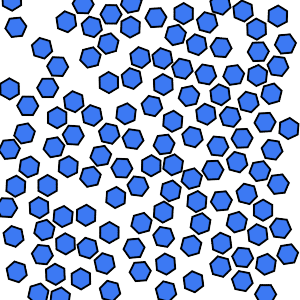

In [3]:
ex_render.render_polygon_frame(system.take_snapshot(all=True), poly_verts)

## Compress the system

Set parameters for the compression. 
* **target_phi** is the target packing fraction. 
* **scale_factor** is the factor by which to scale box length on each step.

This method is prone to get stuck in infinite loops. If scale factor is too small, the scale operation may introduce an overlap that even a maximum trial move displacement cannot remove. When this occurs, the overlap will remain indefinitely and the loop will not terminate.

In [4]:
target_phi = 0.90
scale_factor = 0.995

Monitor the compression progress

In [5]:
d = hoomd.dump.gsd("trajectory-compress.gsd",
                   period=1000,
                   group=hoomd.group.all(),
                   overwrite=True);
log1 = hoomd.analyze.log(filename="log-output.log",
                         quantities=['lx', 'ly', 'xy', 'hpmc_overlap_count'],
                         period=10,
                         overwrite=True);

This example performs 2D compression. Expanding it to 3D is left as an exercise to the reader. The print statements are helpful to debug infinite loops in the compression scheme.

In [6]:
N = len(system.particles);
target_area = N*poly_area / target_phi;
current_area = system.box.get_volume();

while target_area < current_area:
    current_area = max(current_area*scale_factor, target_area);
    new_box = system.box.set_volume(current_area);
   
    hoomd.update.box_resize(Lx=new_box.Lx, Ly=new_box.Ly, Lz=new_box.Lz, period=None);
    
    overlaps = mc.count_overlaps();
    print("phi =", (N*poly_area) / (new_box.get_volume()), ": overlaps =", overlaps, end=' ');
    
    # run until all overlaps are removed
    while overlaps > 0:
        hoomd.run(100, quiet=True);
        overlaps = mc.count_overlaps();
        print(overlaps, end=' ');
        sys.stdout.flush();
        
    print();

phi = 0.5234505862646567 : overlaps = 1 0 
phi = 0.5260809912207607 : overlaps = 2 0 
phi = 0.5287246142922217 : overlaps = 1 0 
phi = 0.5313815219017304 : overlaps = 3 0 
phi = 0.5340517808057592 : overlaps = 3 0 
phi = 0.5367354580962403 : overlaps = 3 0 
phi = 0.5394326212022518 : overlaps = 2 0 
phi = 0.5421433378917102 : overlaps = 2 0 
phi = 0.5448676762730758 : overlaps = 3 0 
phi = 0.5476057047970608 : overlaps = 0 
phi = 0.5503574922583528 : overlaps = 0 
phi = 0.5531231077973395 : overlaps = 3 0 
phi = 0.5559026209018487 : overlaps = 1 0 
phi = 0.5586961014088933 : overlaps = 1 0 
phi = 0.5615036195064252 : overlaps = 2 0 
phi = 0.5643252457351009 : overlaps = 3 0 
phi = 0.5671610509900512 : overlaps = 3 0 
phi = 0.5700111065226644 : overlaps = 1 0 
phi = 0.5728754839423764 : overlaps = 3 0 
phi = 0.5757542552184687 : overlaps = 2 0 
phi = 0.578647492681878 : overlaps = 3 0 
phi = 0.5815552690270133 : overlaps = 3 0 
phi = 0.5844776573135811 : overlaps = 4 0 
phi = 0.58741473

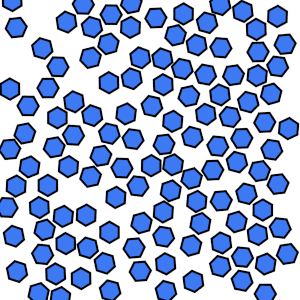

In [7]:
ex_render.display_movie(lambda x: ex_render.render_polygon_frame(x, poly_verts, Ly=initial_Ly), 'trajectory-compress.gsd')

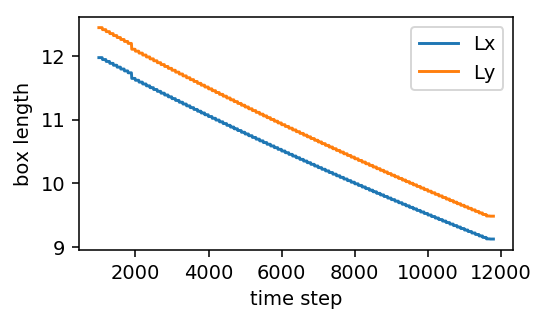

In [8]:
pyplot.figure(figsize=(4,2.2), dpi=140);
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
pyplot.plot(data[:,0], data[:,1], label='Lx');
pyplot.plot(data[:,0], data[:,2], label='Ly');
pyplot.ylabel('box length');
pyplot.xlabel('time step');
pyplot.legend(loc='best');

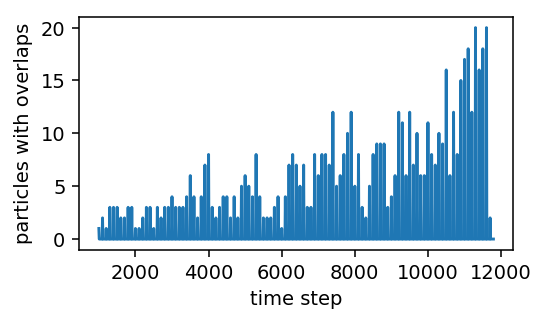

In [9]:
pyplot.figure(figsize=(4,2.2), dpi=140);
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
pyplot.plot(data[:,0], data[:,4]);
pyplot.ylabel('particles with overlaps');
pyplot.xlabel('time step');